In [1]:
import numpy as np
import tensorflow as tf
import tensorlayer as tl
import matplotlib.pyplot as plt
from tensorlayer.layers import *
%matplotlib inline

In [2]:
import cPickle, gzip
f = gzip.open('/home/will/Desktop/data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

In [3]:
Xtrain = np.r_[train_set[0],valid_set[0]]
Ytrain = np.r_[train_set[1],valid_set[1]]
Xtest = test_set[0]
Ytest = test_set[1]

In [4]:
del train_set, valid_set, test_set

In [5]:
def generator(Z,is_train,reuse):
    batchSize = 100
    zHight = 7
    with tf.variable_scope("generator", reuse=reuse):
        tl.layers.set_name_reuse(reuse)
        
        layer = InputLayer(Z,name='input1')
        layer = DenseLayer(layer,zHight*zHight*4,name='dense1')
        layer = BatchNormLayer(layer,act=tf.nn.relu,is_train=is_train,name='batch1')
        layer = ReshapeLayer(layer,[batchSize,zHight,zHight,4],name='reshape1')
        
        layer = DeConv2d(layer,64,(5,5),(zHight*2,zHight*2),batch_size=batchSize,name='deconv1')
        layer = BatchNormLayer(layer,act=tf.nn.relu,is_train=is_train,name='batch2')
        layer = DeConv2d(layer,32,(5,5),(zHight*4,zHight*4),batch_size=batchSize,name='deconv2')
        layer = BatchNormLayer(layer,act=tf.nn.relu,is_train=is_train,name='batch3') 
        layer = DeConv2d(layer,1,(5,5),(zHight*4,zHight*4),(1,1),batch_size=batchSize,\
                         act=tf.nn.sigmoid,name='deconv3')

    return layer.outputs

def discriminator(X,is_train,reuse):

    with tf.variable_scope("discriminator", reuse=reuse):
        tl.layers.set_name_reuse(reuse)
        
        layer = InputLayer(X,name='input1')
        layer = Conv2d(layer,32,(5,5),(2,2),name='conv1')
        layer = BatchNormLayer(layer,act=tf.nn.relu,is_train=is_train,name='batch1')
        layer = Conv2d(layer,64,(5,5),(2,2),name='conv2')
        layer = BatchNormLayer(layer,act=tf.nn.relu,is_train=is_train,name='batch2')
        layer = LambdaLayer(layer,lambda x:tf.reduce_mean(x,[1,2]))
        layer = DenseLayer(layer,64,name='dense1')
        layer = BatchNormLayer(layer,act=tf.nn.relu,is_train=is_train,name='batch3')
        layer = DenseLayer(layer,1,name='dense2',act=tf.nn.sigmoid)
        
    return layer.outputs

In [6]:
class DCGAN(object):
    
    def __init__(self,XShape,zShape,batchSize,r):
        self.X = tf.placeholder(tf.float32,XShape)
        self.Z = tf.placeholder(tf.float32,zShape)
        self.zShape = zShape
        self.r = r
        self.batchSize = batchSize
        
        # Generator
        self.X_fake = generator(self.Z,True,False)
        self.X_sample = generator(self.Z,False,True)
        # Discriminator
        D_fake = discriminator(self.X_fake,True,False)
        D_real = discriminator(self.X,True,True)
        
        # loss
        self.G_loss = -tf.reduce_mean(tf.log(D_fake))
        self.D_loss = -tf.reduce_mean(tf.log(D_real)+tf.log(1-D_fake))
        #loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, 
        #                                                                   labels=tf.ones_like(D_real)*0.9))
        #loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake,
        #                                                                   labels=tf.zeros_like(D_fake)))
        #self.D_loss = loss_real + loss_fake
        #self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))


        # optimizer
        self.optimizer_G = tf.train.AdamOptimizer(learning_rate=self.r)\
                             .minimize(self.G_loss,var_list=tl.layers.get_variables_with_name('generator'))
        self.optimizer_D = tf.train.AdamOptimizer(learning_rate=self.r)\
                             .minimize(self.D_loss,var_list=tl.layers.get_variables_with_name('discriminator'))
        
        # session
        init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _partial_fit(self,X_np):
        #_,_,loss_G,loss_D = self.sess.run([self.optimizer_G,self.optimizer_D,self.G_loss,self.D_loss],
        #                          {self.X:X_np, self.Z:np.random.randn(self.batchSize,self.zShape)})
        _,loss_G = self.sess.run([self.optimizer_G,self.G_loss],
                                          {self.Z:np.random.randn(*self.zShape)})
        _,loss_D = self.sess.run([self.optimizer_D,self.D_loss],
                                          {self.X:X_np, self.Z:np.random.randn(*self.zShape)})        
        return loss_G,loss_D
    
    def fit(self,X,iterations):
        N = X.shape[0]
        n = N/self.batchSize
        for i in range(iterations):
            index_ = np.random.permutation(N)
            cumLoss_G,cumLoss_D = 0,0
            for j in range(n):
                Loss_G,Loss_D = self._partial_fit(X[index_[j*self.batchSize:(j+1)*self.batchSize]])
                cumLoss_G += Loss_G
                cumLoss_D += Loss_D
            print "iter: {}, loss_G: {}, loss_D: {}".format(i,cumLoss_G/n, cumLoss_D/n)        
    
    def sample(self):
        return self.sess.run(self.X_sample,{self.Z:np.random.randn(*self.zShape)})

In [7]:
gan = DCGAN([100,28,28,1],[100,7*7*2],100,1e-4)

  [TL] InputLayer  generator/input1: (100, 98)
  [TL] DenseLayer  generator/dense1: 196 identity
  [TL] BatchNormLayer generator/batch1: decay:0.900000 epsilon:0.000010 act:relu is_train:True
  [TL] ReshapeLayer generator/reshape1: (100, 7, 7, 4)
  [TL] DeConv2dLayer generator/deconv1: shape:[5, 5, 64, 4] out_shape:[100, 14, 14, 64] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer generator/batch2: decay:0.900000 epsilon:0.000010 act:relu is_train:True
  [TL] DeConv2dLayer generator/deconv2: shape:[5, 5, 32, 64] out_shape:[100, 28, 28, 32] strides:[1, 2, 2, 1] pad:SAME act:identity
  [TL] BatchNormLayer generator/batch3: decay:0.900000 epsilon:0.000010 act:relu is_train:True
  [TL] DeConv2dLayer generator/deconv3: shape:[5, 5, 1, 32] out_shape:[100, 28, 28, 1] strides:[1, 1, 1, 1] pad:SAME act:sigmoid
  [TL] InputLayer  generator/input1: (100, 98)
  [TL] DenseLayer  generator/dense1: 196 identity
  [TL] BatchNormLayer generator/batch1: decay:0.900000 epsilon:0.000010 ac

In [9]:
gan.fit(np.reshape(Xtrain,[-1,28,28,1]),20)

iter: 0, loss_G: 0.688041008264, loss_D: 1.33473197142
iter: 1, loss_G: 0.849201429188, loss_D: 1.16896438022
iter: 2, loss_G: 0.971733395159, loss_D: 1.04205858598
iter: 3, loss_G: 1.06848966718, loss_D: 0.975659125646
iter: 4, loss_G: 1.14218802998, loss_D: 0.915778008898
iter: 5, loss_G: 1.17912178278, loss_D: 0.886025906702
iter: 6, loss_G: 1.24463723858, loss_D: 0.844646135668
iter: 7, loss_G: 1.30979791542, loss_D: 0.815860850215
iter: 8, loss_G: 1.38777340949, loss_D: 0.771311238905
iter: 9, loss_G: 1.47086372276, loss_D: 0.72356502374
iter: 10, loss_G: 1.54989153425, loss_D: 0.687126561801
iter: 11, loss_G: 1.6147827663, loss_D: 0.656296362728
iter: 12, loss_G: 1.66956657569, loss_D: 0.63264425983
iter: 13, loss_G: 1.70431568543, loss_D: 0.625898036758
iter: 14, loss_G: 1.7195393906, loss_D: 0.618770528982
iter: 15, loss_G: 1.75051495651, loss_D: 0.613070922295
iter: 16, loss_G: 1.78634268741, loss_D: 0.611743389765
iter: 17, loss_G: 1.805106921, loss_D: 0.604252405564
iter: 18

In [14]:
X_sample = gan.sample()

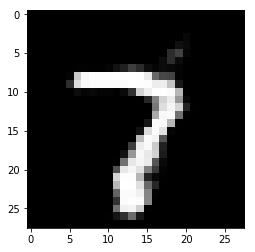

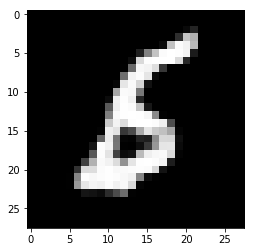

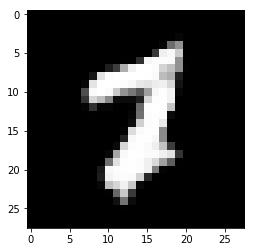

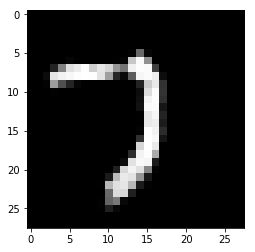

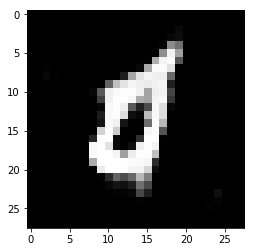

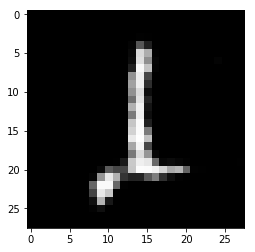

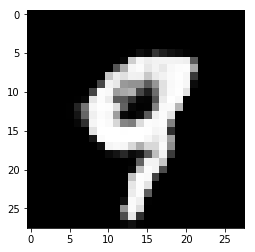

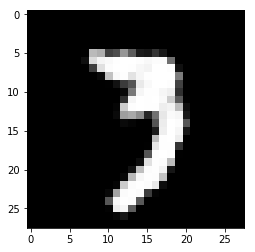

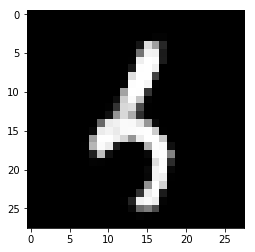

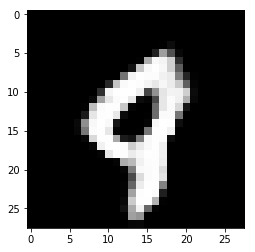

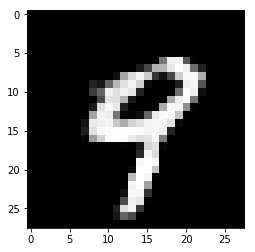

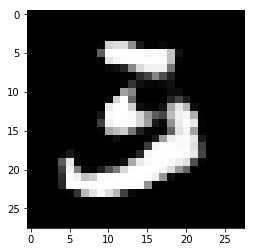

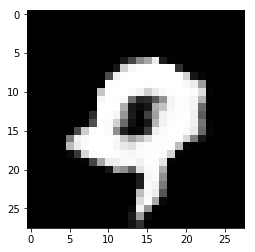

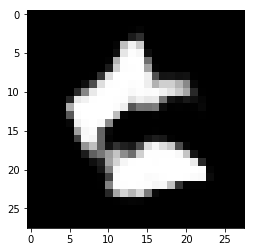

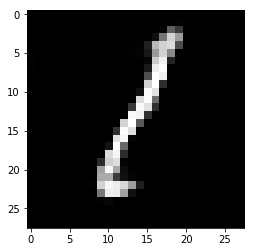

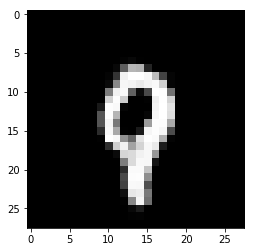

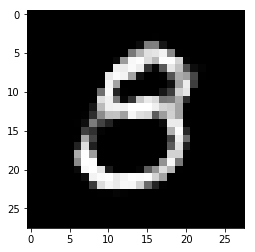

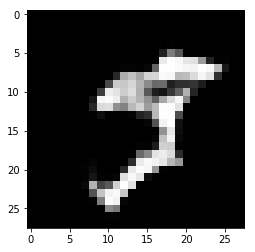

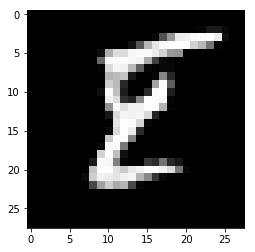

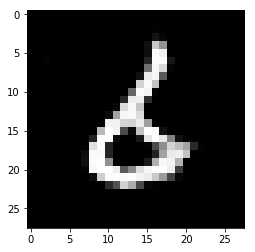

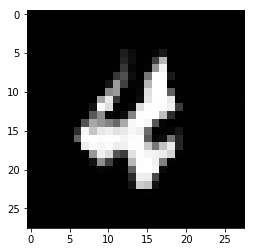

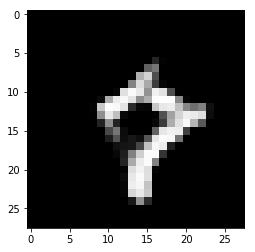

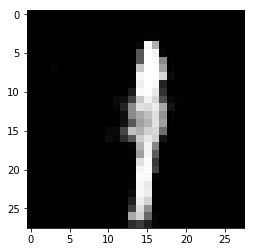

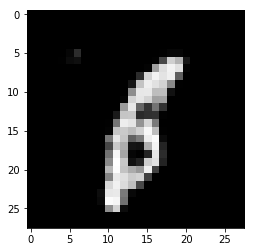

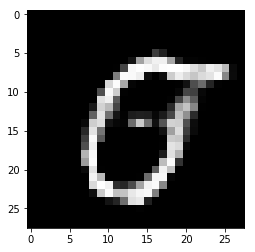

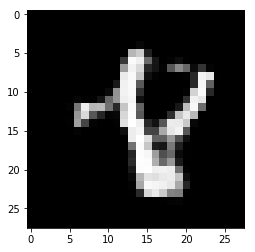

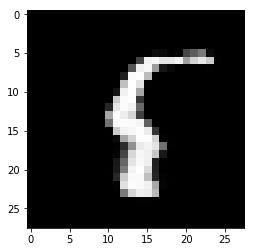

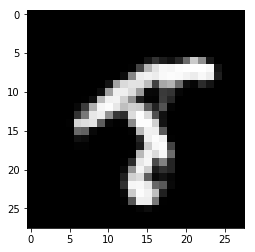

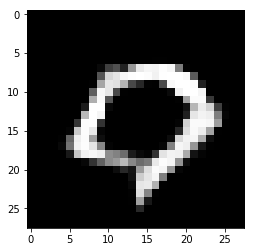

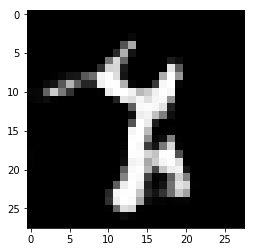

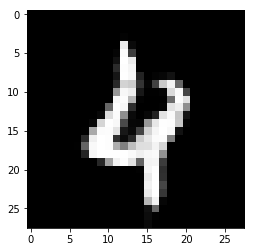

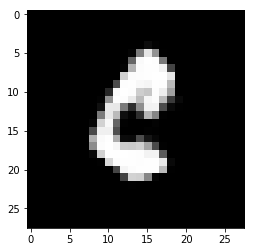

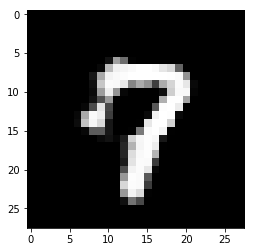

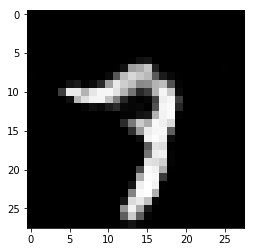

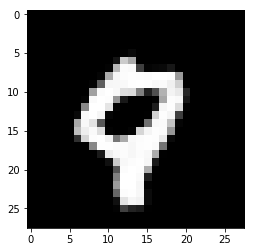

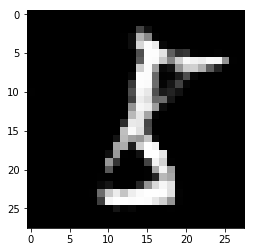

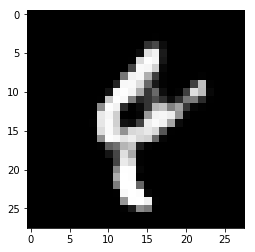

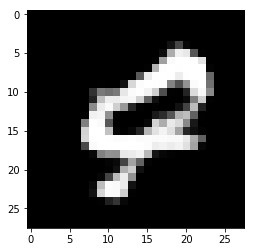

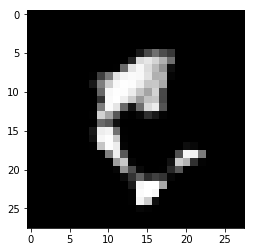

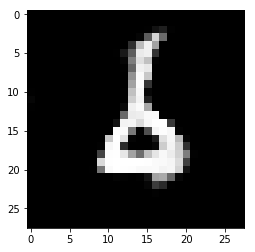

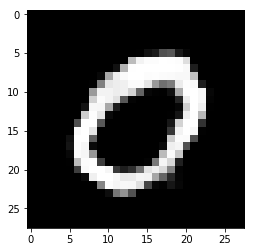

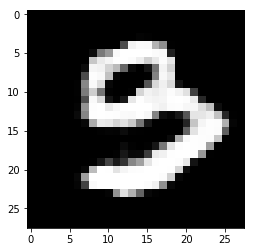

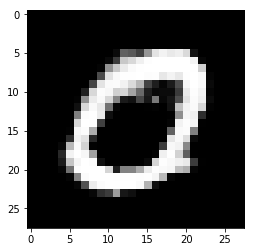

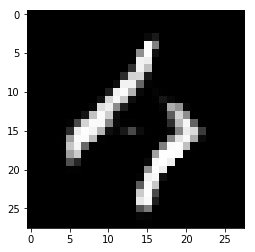

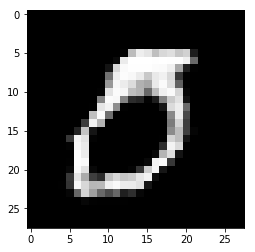

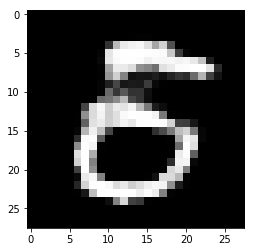

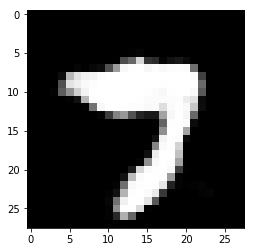

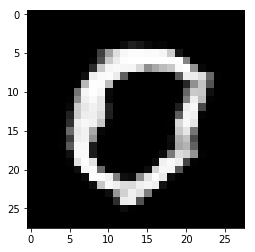

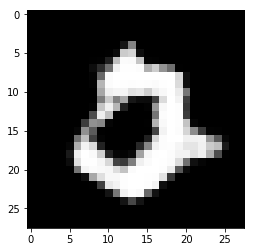

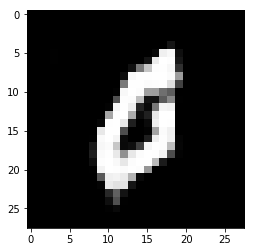

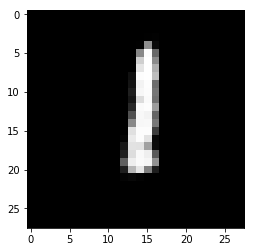

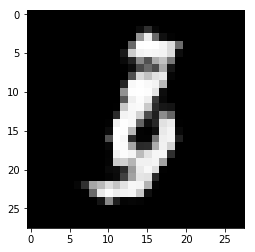

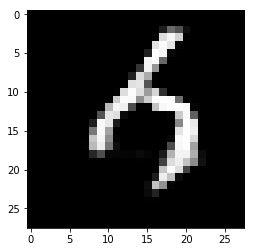

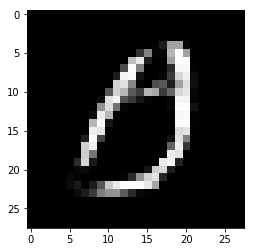

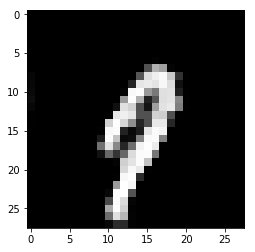

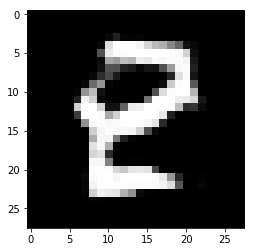

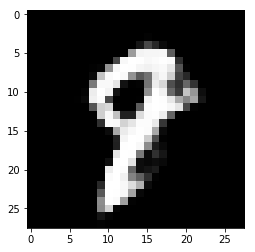

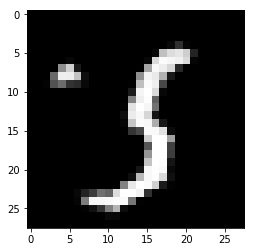

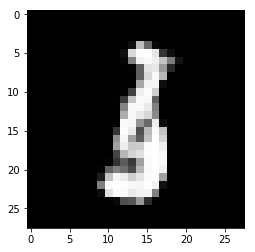

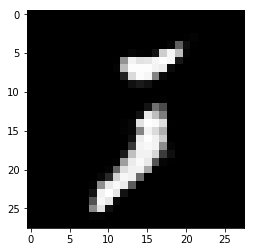

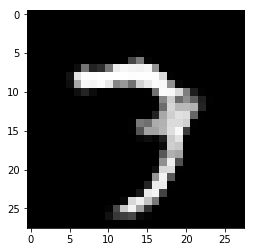

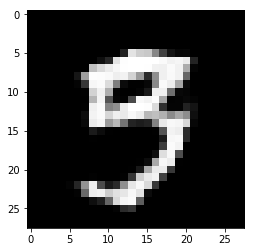

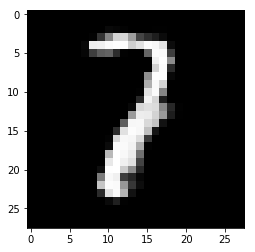

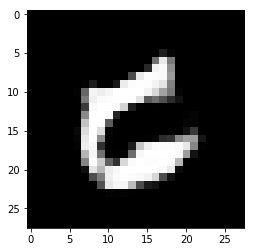

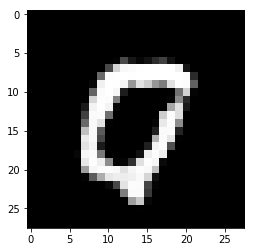

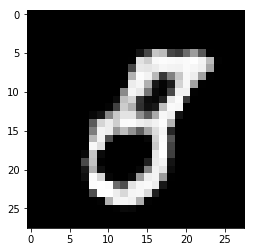

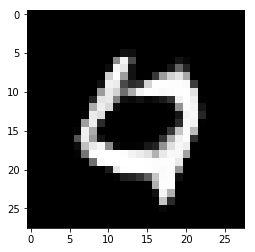

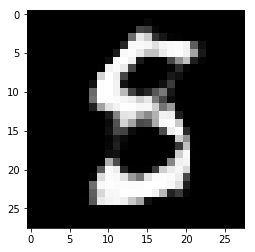

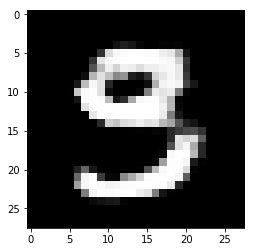

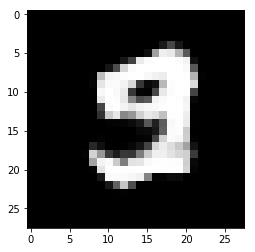

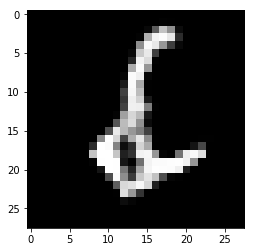

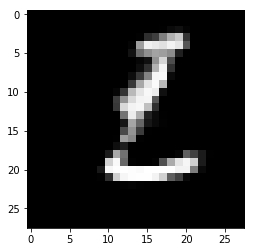

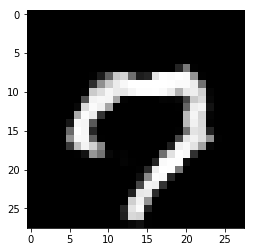

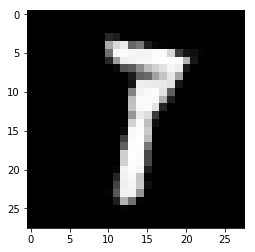

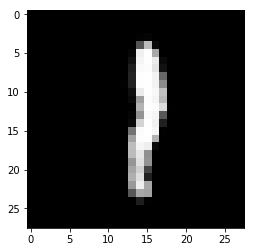

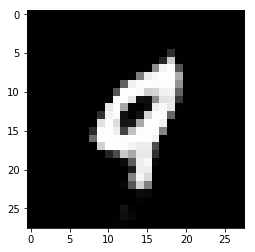

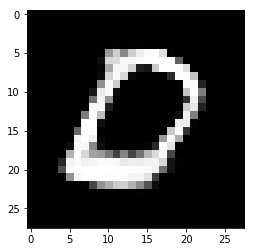

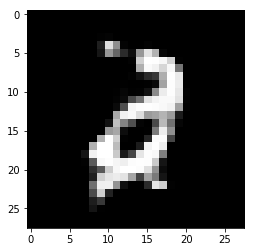

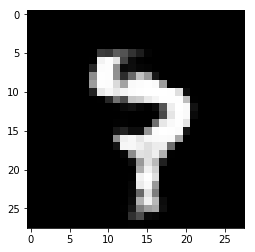

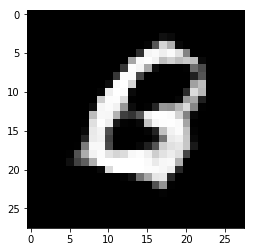

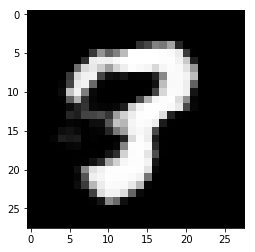

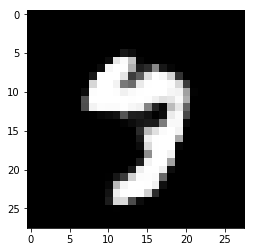

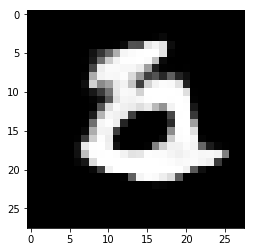

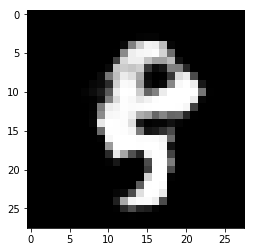

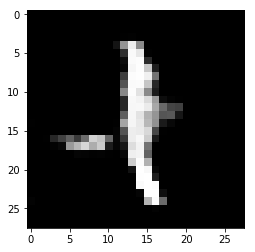

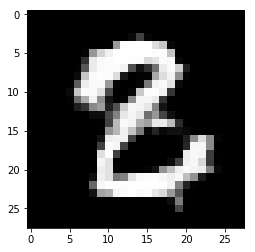

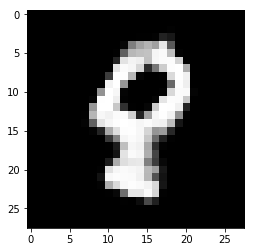

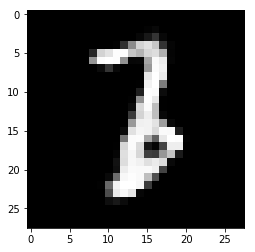

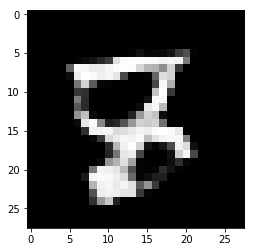

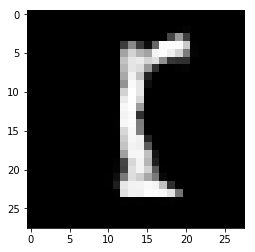

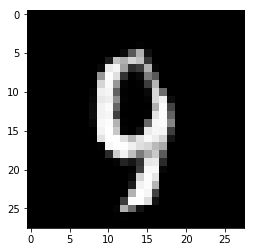

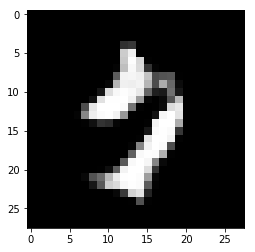

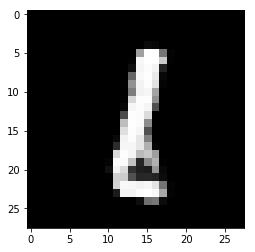

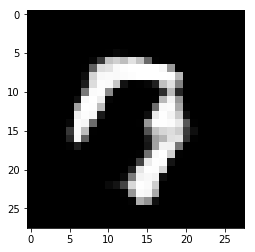

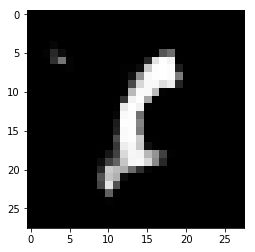

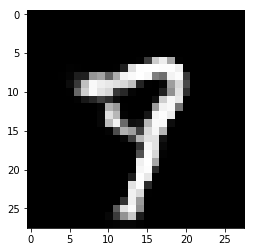

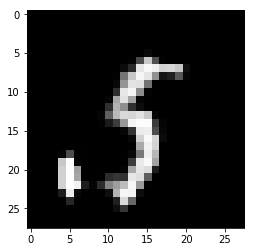

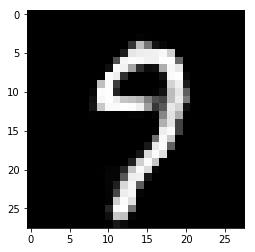

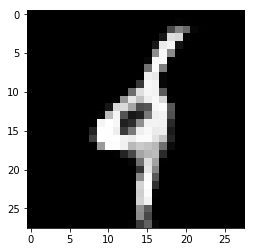

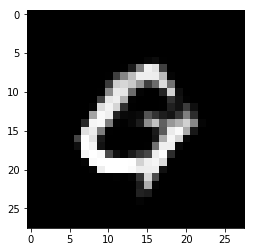

In [15]:
for s in X_sample:
    plt.imshow(np.reshape(s,(28,28)),cmap='gray')
    plt.show()